In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import PredefinedSplit
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import cpu_count


SEED = 93
random.seed(SEED)
np.random.seed(SEED)
n_jobs = cpu_count() - 1

# Gradient Boosting vs NN on MNIST

First, the MNIST dataset is loaded from the CSV files for gradient boosting. For both the methods, a validation is used to tune parameters in order to reduce the amount of computations.

In [2]:
mnist_train_raw = pd.read_csv("./mnist_train.csv")
mnist_train, mnist_validation = train_test_split(mnist_train_raw, test_size=0.3, random_state=SEED, stratify=mnist_train_raw["label"])

mnist_test = pd.read_csv("./mnist_test.csv")
len(mnist_train.columns) - 1

784

The distribution of the labels are giveb below. It seems that the digits are relatively balanced within the dataset.

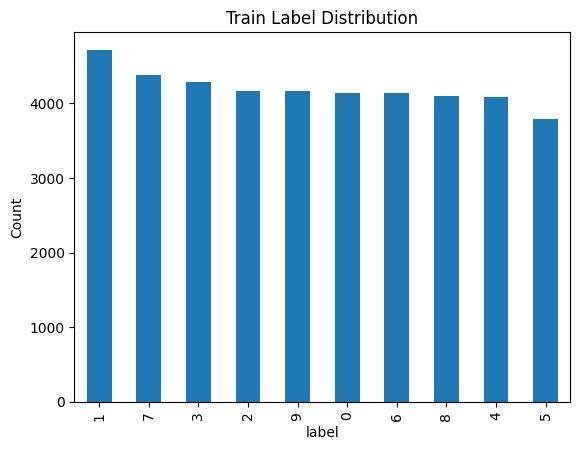

In [3]:
train_counts = mnist_train.loc[:, "label"].value_counts()
test_counts = mnist_test.loc[:, "label"].value_counts()
validation_counts = mnist_validation.loc[:, "label"].value_counts()
train_counts.plot.bar()
plt.title("Train Label Distribution")
plt.ylabel("Count")
plt.show()

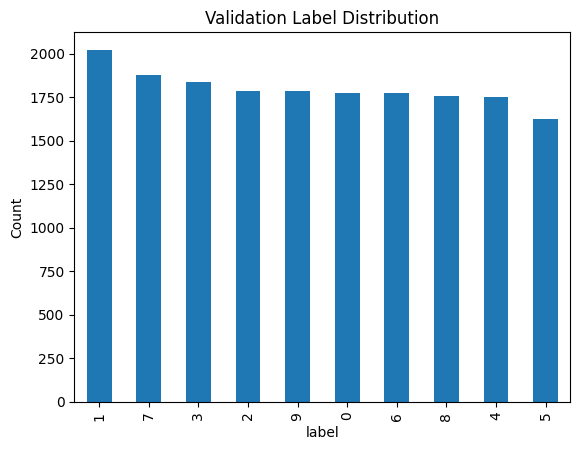

In [4]:
validation_counts.plot.bar()
plt.title("Validation Label Distribution")
plt.ylabel("Count")
plt.show()

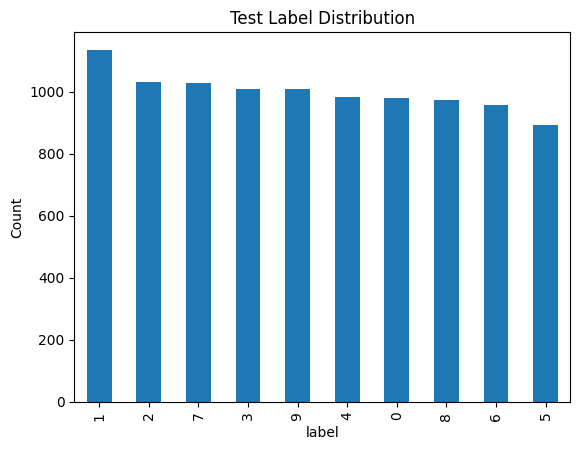

In [5]:
test_counts.plot.bar()
plt.title("Test Label Distribution")
plt.ylabel("Count")
plt.show()

# XGBoost

First, the data are divided into train, validation, and test set.

In [6]:
train_raw_X = mnist_train_raw.drop("label", axis=1)
train_raw_Y = mnist_train_raw["label"]
train_X = mnist_train.drop("label", axis=1)
train_Y = mnist_train["label"]
validation_X = mnist_validation.drop("label", axis=1)
validation_Y = mnist_validation["label"]
test_X = mnist_test.drop("label", axis=1)
test_Y = mnist_test["label"]

Next, XGBoost is fitted by optimizing the Cross Entropy loss (i.e. Maximizing likelihood). The max depth of the tree, the number of boosting rounds, as well as the learning rate are tuned on the validation set.

In [7]:
boost_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("booster", XGBClassifier(objective="multi:softmax", n_jobs=n_jobs,
                              random_state=SEED))
])

param_grid = {
    "booster__max_depth": np.arange(start=2, stop=11, step=2),
    "booster__n_estimators": [100, 200, 300, 400, 500],
    "booster__learning_rate": [0.1, 0.05, 0.01, 0.001]
}

test_fold = pd.Series([0 if i in mnist_validation.index else -1 for i in mnist_train_raw.index])
validation_split = PredefinedSplit(test_fold=test_fold)
boost_search = GridSearchCV(boost_pipe, param_grid=param_grid, cv=validation_split)

Since the data is fairly balanced, the accuracy measurement can summarize the performance without being excessively distorted. On the validation set, the optimal configuration achieved an accuracy of around 98%.

In [8]:
boost_search.fit(train_raw_X, train_raw_Y)
boost_search.best_score_

0.9775555555555555

An examination of the parameter revealed that the maximum attempted boosting round achieved the highest score. Thus, trying more boosting round may improve the accuracy slightly.

In [9]:
boost_search.best_params_

{'booster__learning_rate': 0.1,
 'booster__max_depth': 6,
 'booster__n_estimators': 500}

The test set accuracy is around 98% as well. A closer inspection of all the digits reveals that the performance are fairly uniform across the digits based on the f1-scores. In addition, all metrics are essentially around 98% like the accuracy.

In [10]:
test_pred = boost_search.predict(test_X)
print(classification_report(test_Y, test_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# Basic NN

The data sets are converted to a form that can be consumed by pytorch. Similar to the boosting case, the data are normalized to the scale of \[0, 1\].

In [8]:
class PandasMNISTDataSet(Dataset):

    def __init__(self, df, data_cols, label_col, size=(28, 28)):
        Dataset.__init__(self)
        self.data_frame = df
        self.data_cols = list(data_cols)
        self.label_col = str(label_col)
        self.size = size

    def __len__(self):
        return len(self.data_frame.index)

    def __getitem__(self, item):
        row_vals = self.data_frame.iloc[item][self.data_cols].values / 255.0
        image = np.reshape(row_vals, self.size)
        data_tensor = torch.tensor(np.array([image]))
        return data_tensor, self.data_frame.iloc[item][self.label_col]


data_cols = mnist_train.columns[1:].to_list()
label_col = mnist_train.columns[0]
train_dataset = PandasMNISTDataSet(mnist_train, data_cols, label_col)
validation_dataset = PandasMNISTDataSet(mnist_validation, data_cols, label_col)
test_dataset = PandasMNISTDataSet(mnist_test, data_cols, label_col)
full_train_dataset = PandasMNISTDataSet(mnist_train_raw, data_cols, label_col)

A simple, non-convolution network that just repeatedly reduces the dimensionality of the data is attempted first.

In [9]:
device = "cpu"

class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 98),
            nn.ReLU(),
            nn.Linear(98, 10)
        )

    def forward(self, x):
        x = self.flatten(x).type(torch.float)
        logits = self.linear_relu_stack(x)
        return logits


model = MnistNN().to(device)
print(model)

MnistNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=98, bias=True)
    (5): ReLU()
    (6): Linear(in_features=98, out_features=10, bias=True)
  )
)


The Cross Entropy or Maximum Likelihood loss is used with a 0.01 learning rate and a batch size of 64.

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
full_train_dataloader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

A few helper functions related to training and validating model performance are defined for QoL.

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    batches = 0
    loss_acc = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_acc += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        batches += 1
    correct /= size
    print(f"loss: {loss_acc / batches:>7f}")
    return correct


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct


def predict(dataloader, model, loss):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            prediction = model(X).argmax(1).tolist()
            predictions.extend(prediction)
    return predictions

The training and validation were performed for 100 epoch to get a bigger picture of the model performance over more training rounds.

In [12]:
epochs = 100
train_performance = []
validation_perf = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_acc = train(train_dataloader, model, loss_fn, optimizer)
    validation_acc = test(validation_dataloader, model, loss_fn)
    train_performance.append(train_acc)
    validation_perf.append(validation_acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.268132
Epoch 2
-------------------------------
loss: 1.746057
Epoch 3
-------------------------------
loss: 0.777137
Epoch 4
-------------------------------
loss: 0.491841
Epoch 5
-------------------------------
loss: 0.403898
Epoch 6
-------------------------------
loss: 0.358723
Epoch 7
-------------------------------
loss: 0.327864
Epoch 8
-------------------------------
loss: 0.302030
Epoch 9
-------------------------------
loss: 0.280447
Epoch 10
-------------------------------
loss: 0.260656
Epoch 11
-------------------------------
loss: 0.241634
Epoch 12
-------------------------------
loss: 0.225676
Epoch 13
-------------------------------
loss: 0.210979
Epoch 14
-------------------------------
loss: 0.197447
Epoch 15
-------------------------------
loss: 0.184779
Epoch 16
-------------------------------
loss: 0.173769
Epoch 17
-------------------------------
loss: 0.163748
Epoch 18
-------------------------------
loss: 0.154398
E

An inspection of the accuracy vs epoch graph shows that the validation accuracy quickly climbs in the first 10 epochs. Then, it stabilizes and flattens at around epoch 40. Interestingly, the validation performance did not decrease after flattening out. Thus, overfitting is not as great of an issue as anticipated.

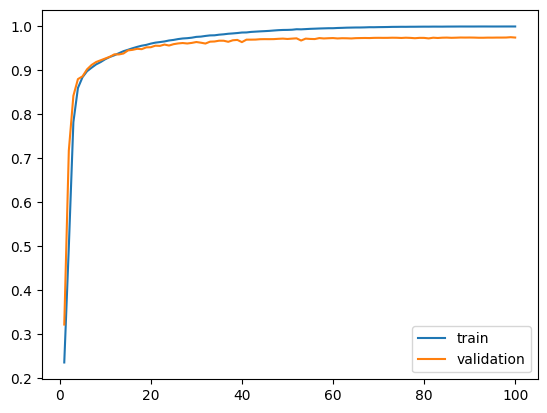

In [13]:
plt.plot(list(range(1, epochs + 1)), train_performance, label="train")
plt.plot(list(range(1, epochs + 1)), validation_perf, label="validation")
plt.legend()
plt.title("Accuracy over epochs of simple NN")
plt.show()

The model is then fit for 75 epochs on the full training set. Since the model did not overfit during the training/validation phase, and the data size is now larger, 75 epochs were picked to ensure that the performance converges similarly to the validation set.

In [14]:
model = MnistNN().to(device)
epochs = 75
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(full_train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.212373
Epoch 2
-------------------------------
loss: 0.995162
Epoch 3
-------------------------------
loss: 0.472797
Epoch 4
-------------------------------
loss: 0.370912
Epoch 5
-------------------------------
loss: 0.320370
Epoch 6
-------------------------------
loss: 0.283504
Epoch 7
-------------------------------
loss: 0.254397
Epoch 8
-------------------------------
loss: 0.229549
Epoch 9
-------------------------------
loss: 0.208971
Epoch 10
-------------------------------
loss: 0.192149
Epoch 11
-------------------------------
loss: 0.176569
Epoch 12
-------------------------------
loss: 0.163603
Epoch 13
-------------------------------
loss: 0.152091
Epoch 14
-------------------------------
loss: 0.141796
Epoch 15
-------------------------------
loss: 0.132487
Epoch 16
-------------------------------
loss: 0.124096
Epoch 17
-------------------------------
loss: 0.116305
Epoch 18
-------------------------------
loss: 0.109445
E

The test set performance is similar to the gradient boosting classifier, and most metrics are around 98%.

In [15]:
test_pred = predict(test_dataloader, model, loss_fn)
print(classification_report(test_Y, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# Convolutional NN

Next, a simple convolutional net inspired by the architecture of the VGG networks is attempted.

In [12]:
class MnistFeature(nn.Module):

    def __init__(self, in_channels, out_channels, padding=1):
        super().__init__()
        self.featurize = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=padding),
            nn.LeakyReLU(),
            nn.Dropout()
        )

    def forward(self, x):
        return self.featurize(x)



class MnistMaxPool(nn.Module):

    def __init__(self, padding=0):
        super().__init__()
        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), padding=padding),
            nn.LeakyReLU(),
            nn.Dropout()
        )

    def forward(self, x):
        return self.pool(x)



class MnistNNConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(MnistFeature(1, 16),
                                     MnistMaxPool(),
                                     MnistFeature(16, 32),
                                     MnistFeature(32, 32),
                                     MnistMaxPool(),
                                     nn.Flatten()
                                     )
        self.detect = nn.Sequential(
            nn.Linear(7 * 7 * 32, 7 * 7 * 32),
            nn.LeakyReLU(),
            nn.Linear(7 * 7 * 32, 7 * 7 * 16),
            nn.LeakyReLU(),
            nn.Linear(7 * 7 * 16, 10)
        )

    def forward(self, x):
        x = x.type(torch.float)
        features = self.feature(x)
        logits = self.detect(features)
        return logits


conv_model = MnistNNConv().to(device)
print(conv_model)

MnistNNConv(
  (feature): Sequential(
    (0): MnistFeature(
      (featurize): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (1): MnistMaxPool(
      (pool): Sequential(
        (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (2): MnistFeature(
      (featurize): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (3): MnistFeature(
      (featurize): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (4): Mnis

The same optimization setting from the non-conv net is used.

In [13]:
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-2)
train_performance = []
validation_perf = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_acc = train(train_dataloader, conv_model, loss_fn, optimizer)
    validation_acc = test(validation_dataloader, conv_model, loss_fn)
    train_performance.append(train_acc)
    validation_perf.append(validation_acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.188230
Epoch 2
-------------------------------
loss: 0.851814
Epoch 3
-------------------------------
loss: 0.548849
Epoch 4
-------------------------------
loss: 0.421420
Epoch 5
-------------------------------
loss: 0.352728
Epoch 6
-------------------------------
loss: 0.303309
Epoch 7
-------------------------------
loss: 0.276216
Epoch 8
-------------------------------
loss: 0.246108
Epoch 9
-------------------------------
loss: 0.228964
Epoch 10
-------------------------------
loss: 0.215208
Epoch 11
-------------------------------
loss: 0.200831
Epoch 12
-------------------------------
loss: 0.192146
Epoch 13
-------------------------------
loss: 0.179914
Epoch 14
-------------------------------
loss: 0.171033
Epoch 15
-------------------------------
loss: 0.164308
Epoch 16
-------------------------------
loss: 0.157351
Epoch 17
-------------------------------
loss: 0.151658
Epoch 18
-------------------------------
loss: 0.146779
E

The accuracy score on validation set shows the same story as the simple NN earlier. However, the performance seems
to be slightly less stable. Overfitting did not seem to be a major issue.

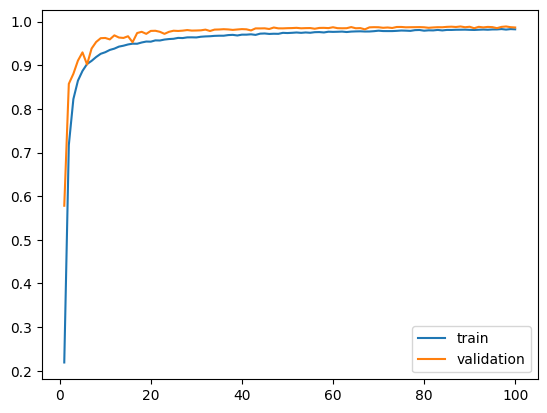

In [14]:
plt.plot(list(range(1, epochs + 1)), train_performance, label="train")
plt.plot(list(range(1, epochs + 1)), validation_perf, label="validation")
plt.legend()
plt.title("Validation performance of convolutional NN")
plt.show()

The full training set is then used with 75 epochs as before.

In [13]:
epochs = 75
conv_model = MnistNNConv().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-2)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(full_train_dataloader, conv_model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.240894
Epoch 2
-------------------------------
loss: 0.800821
Epoch 3
-------------------------------
loss: 0.462063
Epoch 4
-------------------------------
loss: 0.336011
Epoch 5
-------------------------------
loss: 0.271117
Epoch 6
-------------------------------
loss: 0.234980
Epoch 7
-------------------------------
loss: 0.211764
Epoch 8
-------------------------------
loss: 0.195399
Epoch 9
-------------------------------
loss: 0.184049
Epoch 10
-------------------------------
loss: 0.169254
Epoch 11
-------------------------------
loss: 0.160070
Epoch 12
-------------------------------
loss: 0.155828
Epoch 13
-------------------------------
loss: 0.146046
Epoch 14
-------------------------------
loss: 0.141510
Epoch 15
-------------------------------
loss: 0.137475
Epoch 16
-------------------------------
loss: 0.133117
Epoch 17
-------------------------------
loss: 0.126617
Epoch 18
-------------------------------
loss: 0.123493
E

The test set performance of the convolutional net is around 99% for most of the metrics. Thus, it performed slightly better than the gradient boosting and the simple NN.

In [14]:
test_pred = predict(test_dataloader, conv_model, loss_fn)
print(classification_report(test_Y, test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

